# Weighted PCA

This notebook gives a short motivation and demonstration of the weighted PCA algorithm implemented at http://github.com/jakevdp/wpca/

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import numpy as np

/Users/jakevdp/anaconda/envs/python3.5/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## The Data

For simplicity, we will use a straightforward dataset of 1000 sinusoids sampled at a regular interval, with random amplitudes and phases:

$$
x = A \sin[2\pi (t - \phi)]
$$

The benefit of this choice is that we *know* the data lie on a two-dimensional manifold, defined by the eigenvectors

$$
e_1 = \sin(t)\\
e_2 = \cos(t)
$$

Here we will generate the 50-dimensional data and plot the first ten points:

In [2]:
rand = np.random.RandomState(42)

N = 1000
amp = rand.randn(N, 1)
phase = rand.rand(N, 1)
t = np.linspace(0, 1, 50)
Xtrue = amp * np.sin(2 * np.pi * (t - phase))

Xtrue.shape # n_samples x n_features

(1000, 50)

Here are the first ten of these data points:

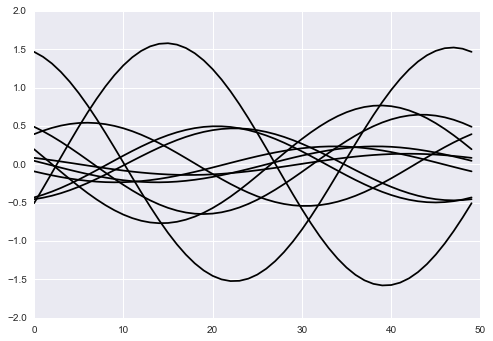

In [3]:
plt.plot(Xtrue[:10].T, c='black');

To make this more interesting, let's add some normally-distributed noise to the data:

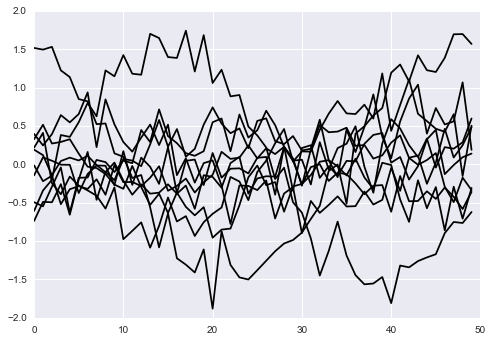

In [4]:
err = 0.2 * np.ones_like(Xtrue)
X = rand.normal(Xtrue, err)
plt.plot(X[:10].T, c='black');

## Reconstructing the Data with PCA

[Principal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is useful for a wide variety of things, but one of those things is the filtering of noise from data.
Under the assumption that the overall variance due to the signal is larger than the overall variance due to the noise, the first few PCA components can be assumed to reflect the de-noised signal.

This is easier to appreciate if we look at it graphically; to this end we'll create a quick convenience routine that we'll use below:

In [5]:
from wpca import PCA, WPCA, EMPCA

def plot_results(Estimator, X, W=None, Xtrue=None, ncomp=2):
    # Compute the standard/weighted PCA
    if W is None:
        pca = Estimator(n_components=10).fit(X)
        Y = Estimator(n_components=ncomp).fit_reconstruct(X)
    else:
        pca = Estimator(n_components=10).fit(X, weights=W)
        Y = Estimator(n_components=ncomp).fit_reconstruct(X, weights=W)
        
    # Create the plots
    fig, ax = plt.subplots(2, 2, figsize=(16, 6))
    if Xtrue is not None:
        ax[0, 0].plot(Xtrue[:10].T, c='gray', lw=1)
        ax[1, 1].plot(Xtrue[:10].T, c='gray', lw=1)
    ax[0, 0].plot(X[:10].T, c='black', lw=1)
    ax[1, 1].plot(Y[:10].T, c='black', lw=1)
    
    ax[0, 1].plot(pca.components_[:ncomp].T, c='black')
    
    ax[1, 0].plot(np.arange(1, 11), pca.explained_variance_ratio_)
    ax[1, 0].set_xlim(1, 10)
    ax[1, 0].set_ylim(0, None)
    
    ax[0, 0].xaxis.set_major_formatter(plt.NullFormatter())
    ax[0, 1].xaxis.set_major_formatter(plt.NullFormatter())
    
    ax[0, 0].set_title('Input Data')
    ax[0, 1].set_title('First {0} Principal Vectors'.format(ncomp))
    ax[1, 1].set_title('Reconstructed Data ({0} components)'.format(ncomp))
    ax[1, 0].set_title('PCA variance ratio')
    ax[1, 0].set_xlabel('principal vector')
    ax[1, 0].set_ylabel('proportion of total variance')
    
    fig.suptitle(Estimator.__name__, fontsize=16)

Now let's plot the reconstruction of the noisy data using standard PCA:

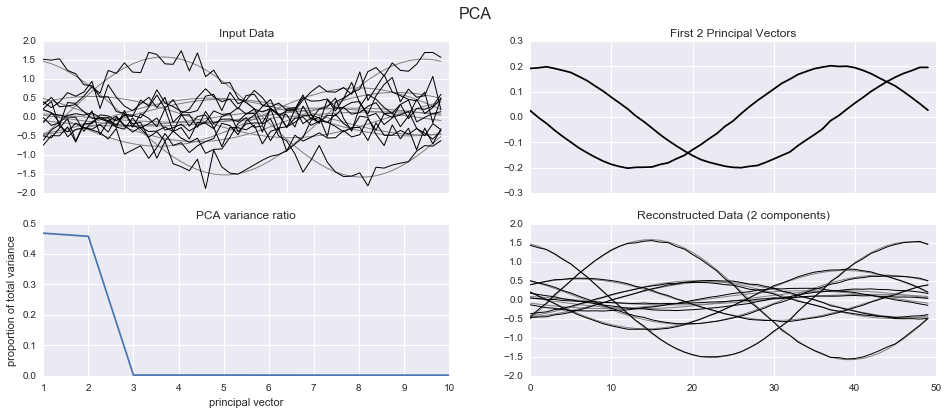

In [6]:
plot_results(PCA, X, Xtrue=Xtrue);

It is clear here that even in the presence of moderate noise, the PCA algorithm found two dominant principal vectors (lower left), and that these principal vectors are the two sinusoids that we expected them to be (upper right).
Further, using these two principal components we can denoise the data, reconstructing the input remarkably well (lower right – gray curves show the true data and black curves show the reconstruction).

## Heteroscedastic Noise

The above works well if your noise is homoscedastic – or, the same for each measurement – but when you have heteroscedastic noise – noise levels which vary from measurement to measurement – PCA is often not as useful.
For example, here we'll add large errors at random to 10% of the values in our dataset.


In [7]:
err = 0.1 * np.ones_like(X)
i = rand.randint(0, err.shape[0], 5000)
j = rand.randint(0, err.shape[1], 5000)
err[i, j] = 10.0
X = rand.normal(Xtrue, err)

Repeating the above exercise, we see that things don't work out quite as well:

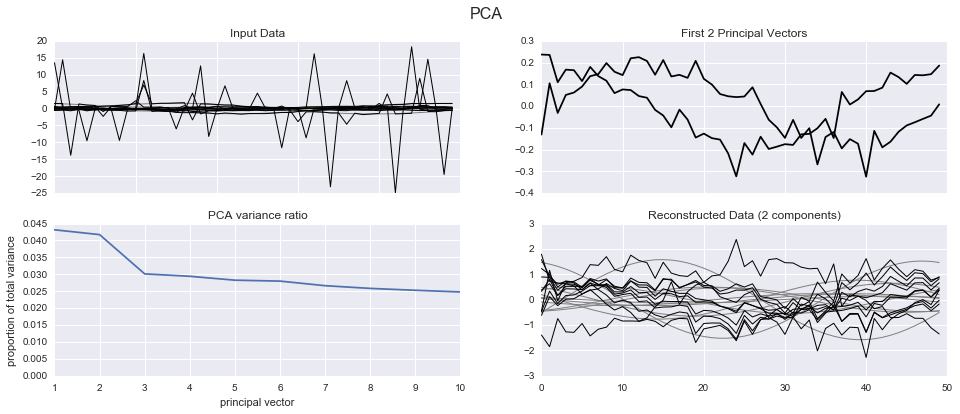

In [8]:
plot_results(PCA, X, Xtrue=Xtrue)

In particular, we no longer have two dominant components: in the presence of heteroscedastic noise, the PCA routine is unable to cleanly separate signal and noise, and we are left with not-so-useful eigenvectors which result in a very poor reconstruction of the data.

Recall that 90% of our data is precisely the same as before: it's only 10% of measured values that have the additional large errors.
We might *hope* that PCA would be able to take this into account, de-weighting the portions of the data that we know are poorly-constrained, but for the standard algorithm this is not the case.

### Weighted PCA

There have been a number of extensions to PCA proposed which can handle weights on each input value.
Here we will use two different approaches to solving the weighted PCA problem:

- ``WPCA`` implements a direct method proposed by [Delchambre (2015)](http://arxiv.org/abs/1412.4533), which solves for principal vectors through an eigenvalue decomposition of the weighted covariance matrix, and then finds the principal coefficients through a weighted least squares procedure computed independently on each sample.

- ``EMPCA`` implements an iterative method proposed by [Bailey (2012)](http://arxiv.org/abs/1208.4122), which uses an expectation-maximization approach to simultaneoulsly solve for the principal vectors and principal coefficients.

In both cases, if the weights are all equal the result reduces to that of standard PCA.
Mathematically, the weights are equivalent to the inverse of the Gaussian errors on each point.
Computing these weights and plotting the weighted PCA with each method, we see a very nice result:

In [9]:
weights = 1. / err

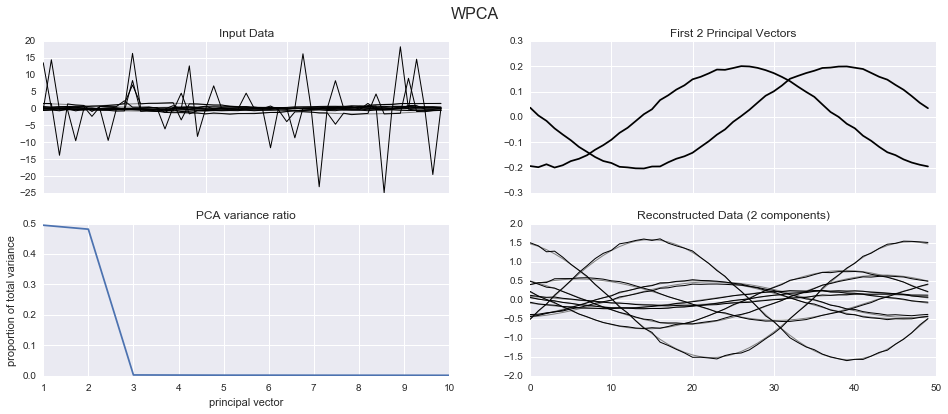

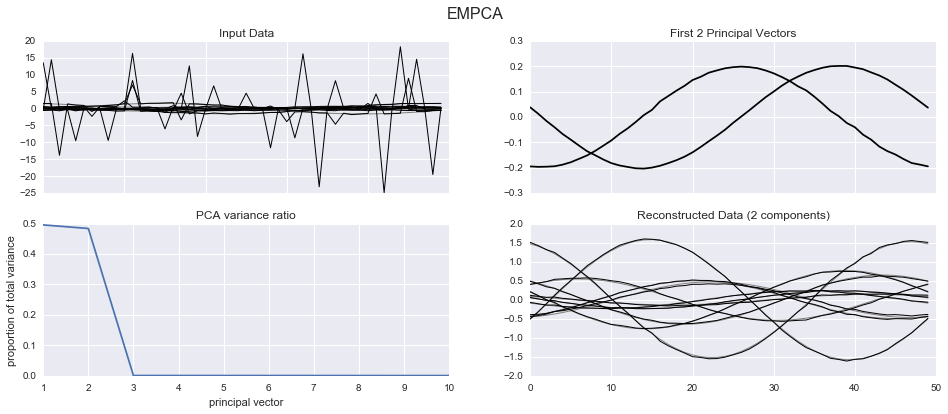

In [10]:
for method in [WPCA, EMPCA]:
    plot_results(method, X, weights, Xtrue=Xtrue)

We see that even with this very noisy data the weighted PCA algorithm can cleanly separate the signal and the noise, and recover the two dominant eigenvectors we would expect.

## Masked Data

At the extreme end of this is data which has missing values: missing values can be viewed as data with infinite errorbars, and thus weights equal to zero.
Here let's convert our outliers to true missing values, and set the weight array to zero to reflect this:

In [11]:
X[i, j] = np.nan
weights[i, j] = 0

Plotting the results, we see that even in the presence of this missing data the principal vectors and the data reconstruction remains robust:

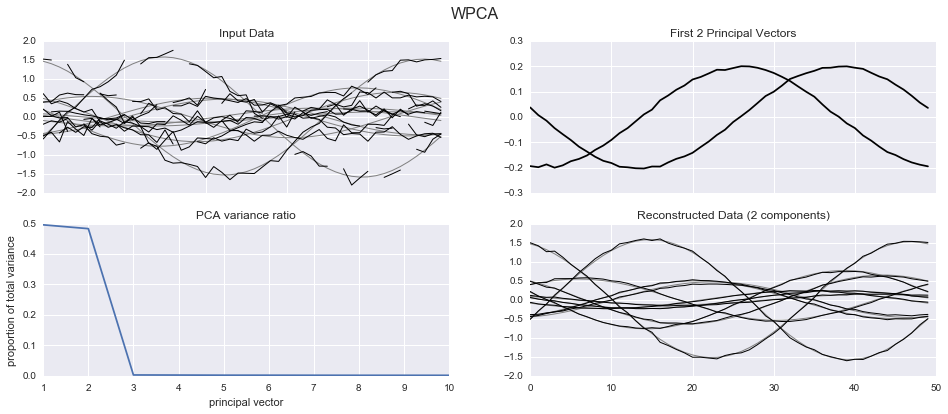

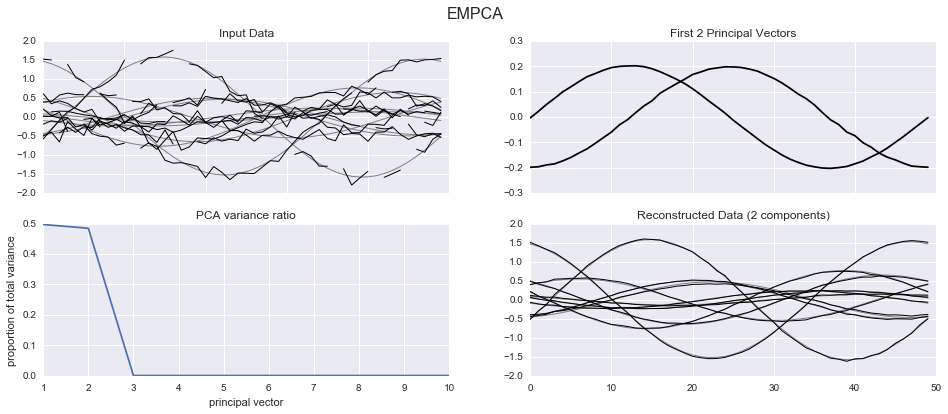

In [12]:
for method in [WPCA, EMPCA]:
    plot_results(method, X, weights, Xtrue=Xtrue)

If you would like to these weighted PCA implementations, see http://github.com/jakevdp/wpca/.